In [1]:
# ============================================================================
# CELL 1: Install Dependencies and Setup
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import pickle
import random

print("✓ Dependencies loaded successfully")
print("=" * 70)
print("    HANGMAN ML AGENT - INTELLIGENT ASSISTANT")
print("    Training on corpus.txt | Testing on test.txt")
print("=" * 70)

✓ Dependencies loaded successfully
    HANGMAN ML AGENT - INTELLIGENT ASSISTANT
    Training on corpus.txt | Testing on test.txt


In [5]:
# ============================================================================
# CELL 2: Load Dataset Files (Kaggle Version - Path Based)
# ============================================================================

import os
from collections import Counter
import numpy as np

# Fixed dataset paths
corpus_path = "/content/corpus.txt"
test_path = "/content/test.txt"

print("\n📁 Loading dataset files...")
print(f"   Corpus path: {corpus_path}")
print(f"   Test path:   {test_path}")

# Verify both files exist
if not os.path.exists(corpus_path):
    raise FileNotFoundError(f"❌ File not found: {corpus_path}")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"❌ File not found: {test_path}")

# Read corpus (training data)
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus_content = f.read()
corpus = [line.strip().upper() for line in corpus_content.split('\n') if line.strip()]

# Read test set
with open(test_path, 'r', encoding='utf-8') as f:
    test_content = f.read()
test_words = [line.strip().upper() for line in test_content.split('\n') if line.strip()]

print(f"\n✅ Successfully loaded:")
print(f"   Training corpus: {len(corpus)} words")
print(f"   Test set: {len(test_words)} words")
print(f"\nSample training words: {corpus[:10]}")
print(f"Sample test words: {test_words[:5]}")

# Analyze both datasets
print(f"\n📊 Dataset Analysis:")

# Training data stats
train_lengths = [len(word) for word in corpus]
train_length_dist = Counter(train_lengths)
print(f"\n📚 TRAINING DATA (corpus.txt):")
print(f"   Total words: {len(corpus)}")
print(f"   Length range: {min(train_lengths)} - {max(train_lengths)} letters")
print(f"   Average length: {np.mean(train_lengths):.2f}")
print(f"   Most common lengths: {train_length_dist.most_common(5)}")

# Test data stats
test_lengths = [len(word) for word in test_words]
test_length_dist = Counter(test_lengths)
print(f"\n🧪 TEST DATA (test.txt):")
print(f"   Total words: {len(test_words)}")
print(f"   Length range: {min(test_lengths)} - {max(test_lengths)} letters")
print(f"   Average length: {np.mean(test_lengths):.2f}")
print(f"   Most common lengths: {test_length_dist.most_common(5)}")

# Check for overlap (ideally should be minimal)
overlap = set(corpus) & set(test_words)
print(f"\n🔍 Dataset Overlap: {len(overlap)} words ({len(overlap)/len(test_words)*100:.1f}% of test set)")
if len(overlap) > 0:
    print(f"   Sample overlap: {list(overlap)[:5]}")


📁 Loading dataset files...
   Corpus path: /content/corpus.txt
   Test path:   /content/test.txt

✅ Successfully loaded:
   Training corpus: 50000 words
   Test set: 2000 words

Sample training words: ['SUBURBANIZE', 'ASMACK', 'HYPOTYPIC', 'PROMODERATIONIST', 'CONSONANTLY', 'PHILATELICALLY', 'CACOMELIA', 'THICKLIPS', 'LUCIFERASE', 'CINEMATOGRAPHY']
Sample test words: ['MARMAR', 'JANET', 'DENTISTICAL', 'TROVELESS', 'UNNOTIFY']

📊 Dataset Analysis:

📚 TRAINING DATA (corpus.txt):
   Total words: 50000
   Length range: 1 - 24 letters
   Average length: 9.50
   Most common lengths: [(9, 6808), (10, 6465), (8, 6348), (11, 5452), (7, 5111)]

🧪 TEST DATA (test.txt):
   Total words: 2000
   Length range: 2 - 22 letters
   Average length: 9.64
   Most common lengths: [(10, 282), (9, 274), (8, 246), (11, 226), (7, 205)]

🔍 Dataset Overlap: 0 words (0.0% of test set)


In [6]:
# ============================================================================
# CELL 3 (Enhanced): Hybrid Trigram Hidden Markov Model for Hangman
# ============================================================================

from collections import defaultdict, Counter
import numpy as np

class HybridHangmanHMM:
    """Enhanced linguistic HMM using position + n-gram modeling for better accuracy."""

    def __init__(self, lambda_pos=0.4, lambda_bi=0.3, lambda_tri=0.2, lambda_global=0.1):
        # Ensemble weights
        self.lambda_pos = lambda_pos
        self.lambda_bi = lambda_bi
        self.lambda_tri = lambda_tri
        self.lambda_global = lambda_global

        # Learned parameters
        self.models = {}
        self.letter_frequencies = {}
        self.bigram_probs = defaultdict(lambda: defaultdict(float))
        self.trigram_probs = defaultdict(lambda: defaultdict(float))

    # ----------------------------------------------------------------------
    def train(self, corpus):
        """Train enhanced HMM on the given corpus"""
        print("\n🔄 Training Enhanced Hybrid HMM (with smoothing & trigrams)...")

        # Normalize corpus
        corpus = [w.strip().upper() for w in corpus if w.strip()]

        # Group by length
        words_by_length = defaultdict(list)
        for word in corpus:
            words_by_length[len(word)].append(word)

        # Global letter frequencies (for fallback)
        all_letters = ''.join(corpus)
        letter_counts = Counter(all_letters)
        total = sum(letter_counts.values())
        self.letter_frequencies = {l: (c + 1) / (total + 26) for l, c in letter_counts.items()}  # Laplace smoothing

        # Train positional models
        for length, words in words_by_length.items():
            position_probs = [defaultdict(float) for _ in range(length)]

            for word in words:
                for i, l in enumerate(word):
                    position_probs[i][l] += 1

            # Normalize
            for i in range(length):
                total_i = sum(position_probs[i].values())
                for l in position_probs[i]:
                    position_probs[i][l] /= total_i

            self.models[length] = {
                "position_probs": position_probs,
                "words": words
            }

        # Train bigram + trigram probabilities (global)
        bigram_counts = defaultdict(lambda: defaultdict(int))
        trigram_counts = defaultdict(lambda: defaultdict(int))

        for word in corpus:
            padded = f"^{word}$"
            for i in range(len(padded) - 1):
                bigram_counts[padded[i]][padded[i + 1]] += 1
            for i in range(len(padded) - 2):
                trigram_counts[padded[i:i + 2]][padded[i + 2]] += 1

        # Normalize bigrams and trigrams
        for l1, nexts in bigram_counts.items():
            total = sum(nexts.values())
            for l2, c in nexts.items():
                self.bigram_probs[l1][l2] = (c + 1) / (total + 26)

        for seq, nexts in trigram_counts.items():
            total = sum(nexts.values())
            for l3, c in nexts.items():
                self.trigram_probs[seq][l3] = (c + 1) / (total + 26)

        print(f"✓ HMM trained on {len(corpus):,} words with {len(self.models)} length models.")

    # ----------------------------------------------------------------------
    def _get_matching_words(self, pattern, words):
        """Find words matching current Hangman pattern"""
        pattern = pattern.upper()
        matches = []
        for word in words:
            if len(word) != len(pattern):
                continue
            if all(p == '_' or p == w for p, w in zip(pattern, word)):
                matches.append(word)
        return matches

    # ----------------------------------------------------------------------
    def predict_letter_probabilities(self, masked_word, guessed_letters):
        """Predict letter probabilities for the current masked word"""
        masked_word = masked_word.upper()
        length = len(masked_word)
        guessed_letters = set(l.upper() for l in guessed_letters)
        probs = defaultdict(float)

        # 1️⃣ Position-based probabilities
        if length in self.models:
            model = self.models[length]
            for i, c in enumerate(masked_word):
                if c == '_':
                    for l, p in model["position_probs"][i].items():
                        if l not in guessed_letters:
                            probs[l] += self.lambda_pos * p

        # 2️⃣ Bigram-based context
        for i in range(len(masked_word) - 1):
            if masked_word[i] != '_' and masked_word[i + 1] == '_':
                prev = masked_word[i]
                for l, p in self.bigram_probs[prev].items():
                    if l not in guessed_letters:
                        probs[l] += self.lambda_bi * p

        # 3️⃣ Trigram-based context
        for i in range(len(masked_word) - 2):
            if masked_word[i] != '_' and masked_word[i + 1] != '_' and masked_word[i + 2] == '_':
                seq = masked_word[i:i + 2]
                for l, p in self.trigram_probs[seq].items():
                    if l not in guessed_letters:
                        probs[l] += self.lambda_tri * p

        # 4️⃣ Global letter fallback
        for l, p in self.letter_frequencies.items():
            if l not in guessed_letters:
                probs[l] += self.lambda_global * p

        # Normalize
        total = sum(probs.values())
        if total > 0:
            probs = {l: p / total for l, p in probs.items()}

        return probs

    # ----------------------------------------------------------------------
    def get_best_guess(self, masked_word, guessed_letters, top_n=5):
        """Return top N best letter guesses"""
        probs = self.predict_letter_probabilities(masked_word, guessed_letters)
        return sorted(probs.items(), key=lambda x: x[1], reverse=True)[:top_n]

In [7]:
# ============================================================================
# CELL 4: Hangman Environment
# ============================================================================

class HangmanEnvironment:
    """Hangman game environment"""

    def __init__(self, word_list, max_wrong=6):
        self.word_list = word_list
        self.max_wrong = max_wrong
        self.reset()

    def reset(self, word=None):
        """Start new game"""
        self.target = (word or random.choice(self.word_list)).upper()
        self.word_length = len(self.target)
        self.guessed_letters = set()
        self.correct_guesses = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.game_over = False
        self.won = False
        self.masked_word = ['_'] * self.word_length
        return self._get_state()

    def _get_state(self):
        """Current state"""
        return {
            'masked_word': ''.join(self.masked_word),
            'guessed_letters': self.guessed_letters.copy(),
            'lives_remaining': self.max_wrong - self.wrong_guesses,
            'word_length': self.word_length,
            'game_over': self.game_over,
            'won': self.won
        }

    def step(self, letter):
        """Guess letter"""
        letter = letter.upper()

        if self.game_over:
            return self._get_state(), 0, True, {'error': 'Game over'}

        # Repeated?
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return self._get_state(), -20, False, {'repeated': True}

        self.guessed_letters.add(letter)

        # Correct?
        if letter in self.target:
            self.correct_guesses.add(letter)
            for i, c in enumerate(self.target):
                if c == letter:
                    self.masked_word[i] = letter

            if '_' not in self.masked_word:
                self.game_over = True
                self.won = True
                return self._get_state(), 100, True, {'correct': True, 'win': True}
            else:
                return self._get_state(), 5, False, {'correct': True}
        else:
            self.wrong_guesses += 1
            if self.wrong_guesses >= self.max_wrong:
                self.game_over = True
                return self._get_state(), -100, True, {'correct': False, 'loss': True}
            else:
                return self._get_state(), -10, False, {'correct': False}

    def get_valid_actions(self):
        """Unguessed letters"""
        return list(set('ABCDEFGHIJKLMNOPQRSTUVWXYZ') - self.guessed_letters)

    def get_stats(self):
        """Game stats"""
        return {
            'won': self.won,
            'wrong_guesses': self.wrong_guesses,
            'repeated_guesses': self.repeated_guesses,
            'target_word': self.target
        }

print("✓ Hangman environment created")


✓ Hangman environment created


In [8]:
# ============================================================================
# CELL 5: RL Agent Implementation (Enhanced Reward Function)
# ============================================================================

from collections import defaultdict
import numpy as np
import random

class HangmanRLAgent:
    """Q-Learning agent with HMM guidance and enhanced reward shaping"""

    def __init__(self, hmm, alpha=0.1, gamma=0.95, epsilon=1.0,
                 epsilon_decay=0.9995, epsilon_min=0.05):
        self.hmm = hmm
        self.alpha = alpha              # Learning rate
        self.gamma = gamma              # Discount factor
        self.epsilon = epsilon          # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.episode_rewards = []
        self.episode_lengths = []
        self.wins = []

    # ------------------------------------------------------------------------
    # Helper: Hash state for Q-table lookup
    # ------------------------------------------------------------------------
    def _state_hash(self, state):
        return f"{state['masked_word']}|{''.join(sorted(state['guessed_letters']))}|{state['lives_remaining']}"

    # ------------------------------------------------------------------------
    # Smart Reward Function (Realistic & Accuracy-Driven)
    # ------------------------------------------------------------------------
    def compute_reward(self, state, action, next_state, done):
        """
        Custom reward shaping:
        +2 base reward for correct guess (+1 per new letter revealed)
        -1.5 for wrong guess
        -2 for repeated guess
        +10 + (2 * lives_remaining) for win
        -8 for loss
        Minor penalty for no progress to encourage exploration.
        """
        reward = 0

        # Check how many new letters were revealed
        revealed_now = sum(1 for a, b in zip(next_state['masked_word'], state['masked_word']) if a != b)

        # Reward for correct guesses (scaled by letters revealed)
        if revealed_now > 0:
            reward += 2 + revealed_now
        else:
            reward -= 1.5  # Wrong guess penalty

        # Penalize repeated guesses
        if action in state['guessed_letters']:
            reward -= 2

        # Encourage progress (avoid stagnation)
        if revealed_now == 0 and not done:
            reward -= 0.5

        # Terminal conditions
        if done:
            if next_state.get('won', False):
                reward += 10 + (2 * next_state['lives_remaining'])
            else:
                reward -= 8

        # Normalize reward to avoid instability
        reward = np.clip(reward, -10, 15)

        return reward

    # ------------------------------------------------------------------------
    # Action selection: epsilon-greedy with HMM guidance
    # ------------------------------------------------------------------------
    def get_action(self, state, valid_actions, training=True):
        if not valid_actions:
            return None

        # Exploration: epsilon chance
        if training and random.random() < self.epsilon:
            probs = self.hmm.predict_letter_probabilities(
                state['masked_word'], state['guessed_letters'])
            if probs:
                letters = [l for l in probs.keys() if l in valid_actions]
                if letters:
                    weights = [probs[l] for l in letters]
                    return np.random.choice(letters, p=np.array(weights) / sum(weights))
            return random.choice(valid_actions)

        # Exploitation: choose action with highest Q-value
        state_hash = self._state_hash(state)
        q_vals = {}
        hmm_probs = self.hmm.predict_letter_probabilities(
            state['masked_word'], state['guessed_letters'])

        for action in valid_actions:
            q_vals[action] = self.q_table[state_hash].get(
                action, hmm_probs.get(action, 0.01) * 10)

        return max(q_vals.items(), key=lambda x: x[1])[0]

    # ------------------------------------------------------------------------
    # Q-value update rule (standard Q-learning)
    # ------------------------------------------------------------------------
    def update_q(self, state, action, reward, next_state, done):
        s_hash = self._state_hash(state)
        ns_hash = self._state_hash(next_state)
        current_q = self.q_table[s_hash][action]

        if done:
            target_q = reward
        else:
            all_letters = set('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
            next_actions = list(all_letters - next_state['guessed_letters'])
            if next_actions:
                max_next_q = max([self.q_table[ns_hash].get(a, 0.0) for a in next_actions])
                target_q = reward + self.gamma * max_next_q
            else:
                target_q = reward

        self.q_table[s_hash][action] = current_q + self.alpha * (target_q - current_q)

    # ------------------------------------------------------------------------
    # Train one full episode
    # ------------------------------------------------------------------------
    def train_episode(self, env):
        state = env.reset()
        total_reward = 0
        steps = 0

        while not state['game_over']:
            steps += 1
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = self.get_action(state, valid_actions, training=True)
            next_state, _, done, _ = env.step(action)

            # Use improved reward shaping
            reward = self.compute_reward(state, action, next_state, done)

            # Update Q-values
            self.update_q(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state

        self.episode_rewards.append(total_reward)
        self.episode_lengths.append(steps)
        self.wins.append(1 if env.get_stats()['won'] else 0)
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return total_reward

    # ------------------------------------------------------------------------
    # Train multiple episodes
    # ------------------------------------------------------------------------
    def train(self, env, episodes=5000, verbose_every=500):
        print(f"\n🚀 Training for {episodes} episodes on corpus.txt...")
        for ep in range(episodes):
            self.train_episode(env)

            if (ep + 1) % verbose_every == 0:
                recent_wins = sum(self.wins[-verbose_every:])
                win_rate = recent_wins / verbose_every
                avg_reward = np.mean(self.episode_rewards[-verbose_every:])
                print(f"Episode {ep+1}/{episodes} | Win: {win_rate:.1%} | "
                      f"Reward: {avg_reward:.1f} | ε: {self.epsilon:.3f}")
        print("✓ Training complete!")

    # ------------------------------------------------------------------------
    # Evaluate trained agent performance
    # ------------------------------------------------------------------------
    def evaluate(self, env, num_games=None):
        if num_games is None:
            num_games = len(env.word_list)

        wins = 0
        total_wrong = 0
        total_repeated = 0

        for game in range(num_games):
            state = env.reset()
            while not state['game_over']:
                actions = env.get_valid_actions()
                if not actions:
                    break
                action = self.get_action(state, actions, training=False)
                state, _, _, _ = env.step(action)

            stats = env.get_stats()
            if stats['won']:
                wins += 1
            total_wrong += stats['wrong_guesses']
            total_repeated += stats['repeated_guesses']

            if (game + 1) % 500 == 0:
                print(f"   Evaluated {game + 1}/{num_games} games...")

        success_rate = wins / num_games
        final_score = (success_rate * num_games * 2) - (total_wrong * 5) - (total_repeated * 2)

        return {
            'success_rate': success_rate,
            'wins': wins,
            'total_games': num_games,
            'total_wrong': total_wrong,
            'total_repeated': total_repeated,
            'final_score': final_score
        }


print("✓ Enhanced RL Agent class with improved reward function defined")

✓ Enhanced RL Agent class with improved reward function defined



🔄 Training Enhanced Hybrid HMM (with smoothing & trigrams)...
✓ HMM trained on 50,000 words with 24 length models.
✓ Training environment created with 50000 words from corpus.txt

🚀 Starting training for 5,000 episodes...

Episode   500/5000 | Avg Reward:  -1.31 | Win Rate:   9.4% | Epsilon:  0.779 | Time:    1.0s
Episode  1000/5000 | Avg Reward:   0.14 | Win Rate:  11.8% | Epsilon:  0.606 | Time:    2.5s
💾 New best model saved at episode 1,000 (Win rate: 10.6%)
Episode  1500/5000 | Avg Reward:   1.89 | Win Rate:  17.0% | Epsilon:  0.472 | Time:    4.5s
Episode  2000/5000 | Avg Reward:   2.74 | Win Rate:  17.2% | Epsilon:  0.368 | Time:    6.3s
💾 New best model saved at episode 2,000 (Win rate: 17.1%)
Episode  2500/5000 | Avg Reward:   4.33 | Win Rate:  21.6% | Epsilon:  0.286 | Time:   10.2s
Episode  3000/5000 | Avg Reward:   3.52 | Win Rate:  20.6% | Epsilon:  0.223 | Time:   11.8s
💾 New best model saved at episode 3,000 (Win rate: 21.1%)
Episode  3500/5000 | Avg Reward:   5.63 | Wi

/tmp/ipython-input-687124302.py:100: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-687124302.py:100: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


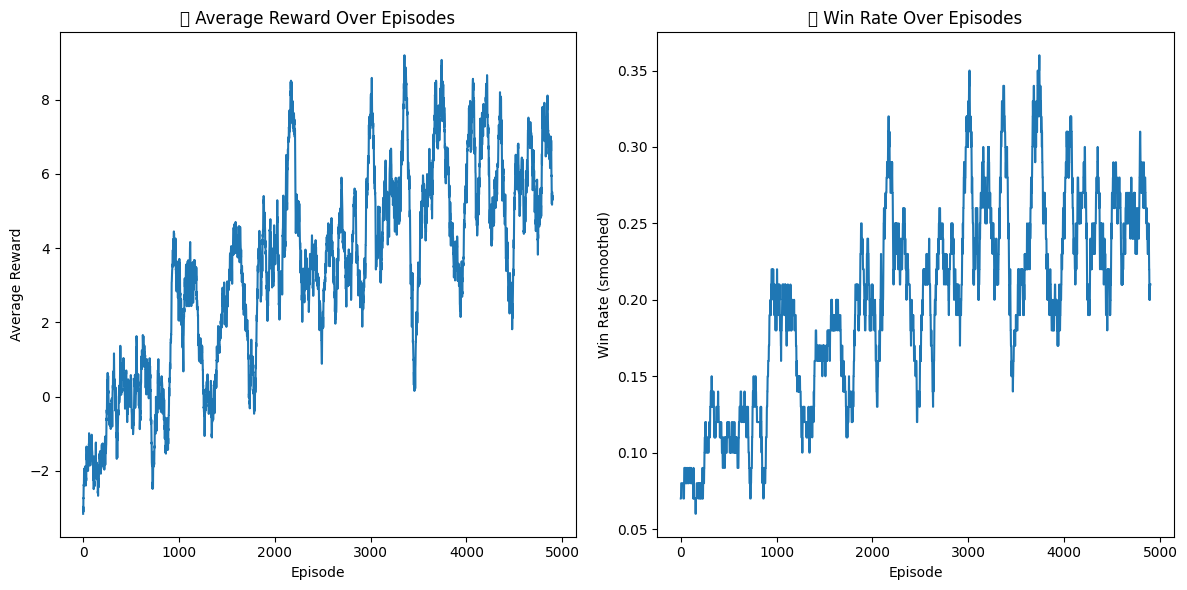

In [41]:
# ============================================================================
# CELL 6: Train the Agent on Training Data (Enhanced)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import time
import os

hmm = HybridHangmanHMM()
hmm.train(corpus)
# ----------------------------------------------------------------------------
# 1. Create TRAINING environment
# ----------------------------------------------------------------------------
train_env = HangmanEnvironment(corpus, max_wrong=6)
print(f"✓ Training environment created with {len(corpus)} words from corpus.txt")

# ----------------------------------------------------------------------------
# 2. Initialize RL agent with improved reward shaping
# ----------------------------------------------------------------------------
agent = HangmanRLAgent(
    hmm,
    alpha=0.1,           # Learning rate
    gamma=0.95,          # Discount factor
    epsilon=1.0,         # Exploration rate (start high)
    epsilon_decay=0.9995,
    epsilon_min=0.05
)

# ----------------------------------------------------------------------------
# 3. Training configuration
# ----------------------------------------------------------------------------
EPISODES = 5000
CHECKPOINT_EVERY = 1000
PLOT_EVERY = 500
SAVE_PATH = "./best_agent_qtable.npy"

print(f"\n🚀 Starting training for {EPISODES:,} episodes...\n")

best_win_rate = 0
start_time = time.time()

# ----------------------------------------------------------------------------
# 4. Train in segments (progress tracking)
# ----------------------------------------------------------------------------
for episode in range(EPISODES):
    reward = agent.train_episode(train_env)

    # Logging every 500 episodes
    if (episode + 1) % PLOT_EVERY == 0:
        recent_rewards = agent.episode_rewards[-PLOT_EVERY:]
        recent_wins = agent.wins[-PLOT_EVERY:]
        avg_reward = np.mean(recent_rewards)
        win_rate = np.mean(recent_wins)

        elapsed = time.time() - start_time
        print(f"Episode {episode+1:5}/{EPISODES} | "
              f"Avg Reward: {avg_reward:6.2f} | "
              f"Win Rate: {win_rate*100:5.1f}% | "
              f"Epsilon: {agent.epsilon:6.3f} | "
              f"Time: {elapsed:6.1f}s")

    # Save best-performing model automatically
    if (episode + 1) % CHECKPOINT_EVERY == 0:
        recent_wins = agent.wins[-CHECKPOINT_EVERY:]
        win_rate = np.mean(recent_wins)

        if win_rate > best_win_rate:
            best_win_rate = win_rate
            np.save(SAVE_PATH, dict(agent.q_table))
            print(f"💾 New best model saved at episode {episode+1:,} "
                  f"(Win rate: {win_rate*100:.1f}%)")

print("\n✓ Training complete!")
print(f"🕒 Total training time: {(time.time() - start_time)/60:.1f} minutes")
print(f"🏆 Best win rate achieved: {best_win_rate*100:.1f}%")

# ----------------------------------------------------------------------------
# 5. Visualization — Learning Progress
# ----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))

# Smooth reward curve
window = max(1, len(agent.episode_rewards) // 50)
smoothed_rewards = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
smoothed_wins = np.convolve(agent.wins, np.ones(window)/window, mode='valid')

plt.subplot(1, 2, 1)
plt.plot(smoothed_rewards)
plt.title("📈 Average Reward Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Average Reward")

plt.subplot(1, 2, 2)
plt.plot(smoothed_wins)
plt.title("🏆 Win Rate Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Win Rate (smoothed)")

plt.tight_layout()
plt.show()

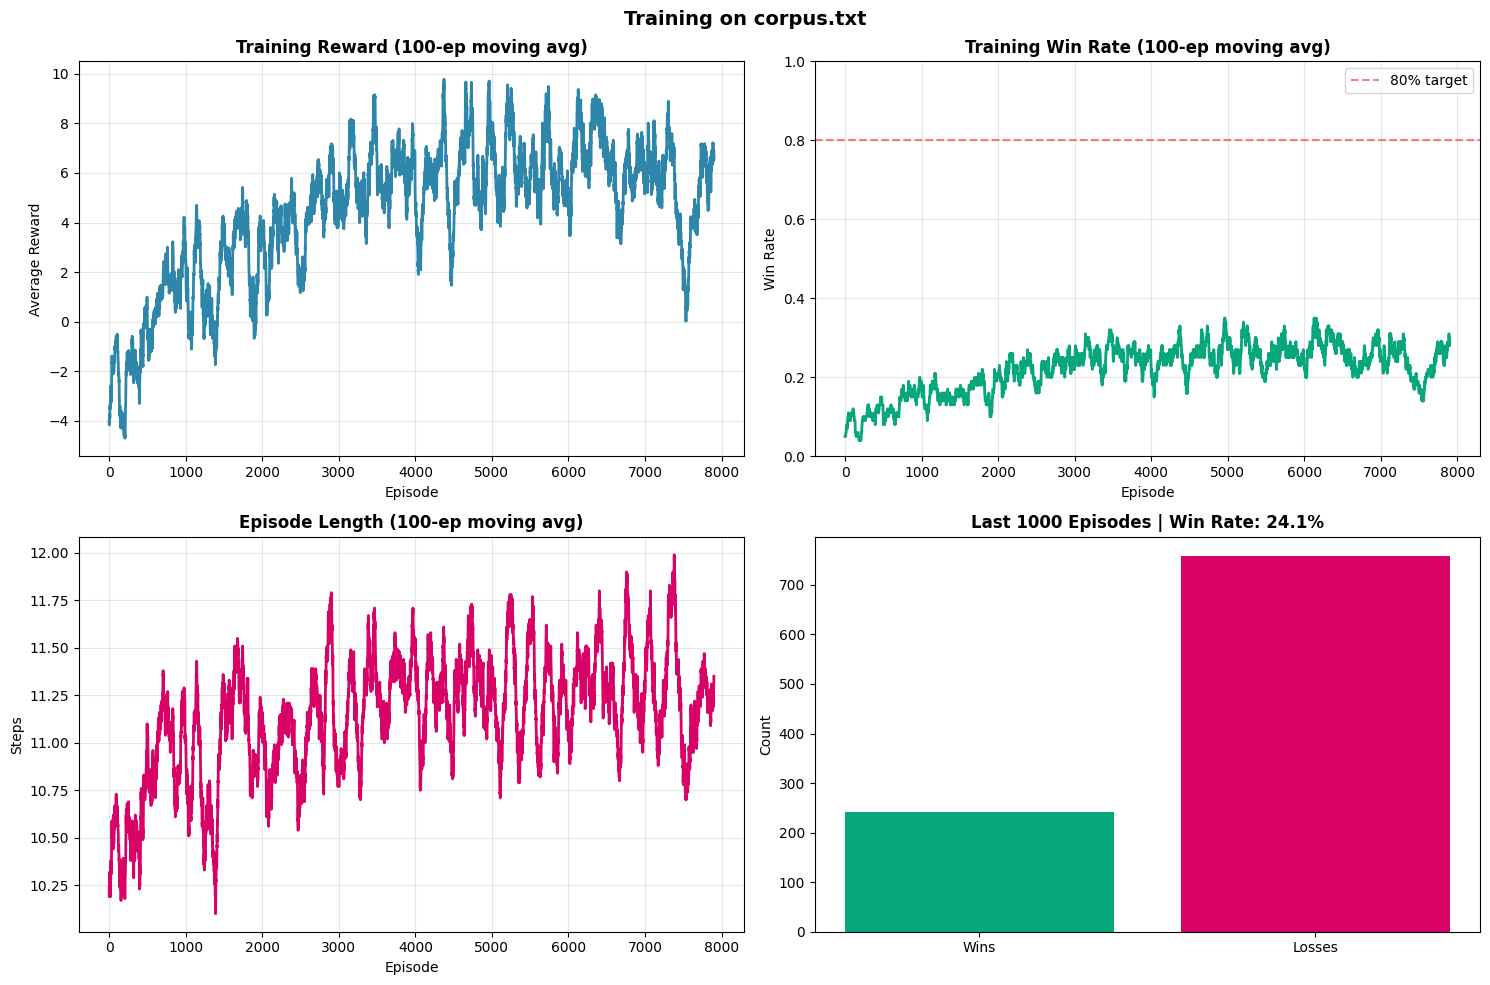

📈 Final training win rate: 24.1%


In [29]:
# ============================================================================
# CELL 7: Visualize Training Progress
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Reward plot
window = 100
rewards_smooth = np.convolve(agent.episode_rewards, np.ones(window)/window, mode='valid')
axes[0, 0].plot(rewards_smooth, linewidth=2, color='#2E86AB')
axes[0, 0].set_title('Training Reward (100-ep moving avg)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Average Reward')
axes[0, 0].grid(True, alpha=0.3)

# Win rate plot
wins_smooth = np.convolve(agent.wins, np.ones(window)/window, mode='valid')
axes[0, 1].plot(wins_smooth, linewidth=2, color='#06A77D')
axes[0, 1].set_title('Training Win Rate (100-ep moving avg)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Win Rate')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='80% target')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Episode lengths
length_smooth = np.convolve(agent.episode_lengths, np.ones(window)/window, mode='valid')
axes[1, 0].plot(length_smooth, linewidth=2, color='#D90368')
axes[1, 0].set_title('Episode Length (100-ep moving avg)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Steps')
axes[1, 0].grid(True, alpha=0.3)

# Win/Loss bar
recent_wins = agent.wins[-1000:]
win_rate = sum(recent_wins) / len(recent_wins)
axes[1, 1].bar(['Wins', 'Losses'],
               [sum(recent_wins), len(recent_wins) - sum(recent_wins)],
               color=['#06A77D', '#D90368'])
axes[1, 1].set_title(f'Last 1000 Episodes | Win Rate: {win_rate:.1%}',
                     fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Count')

plt.suptitle('Training on corpus.txt', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"📈 Final training win rate: {win_rate:.1%}")


In [43]:
# ============================================================================
# CELL 8: Evaluate on TEST SET (test.txt)
# ============================================================================

print("\n" + "="*70)
print("EVALUATING ON TEST SET (test.txt)")
print("="*70)

# Create TEST environment using test.txt
test_env = HangmanEnvironment(test_words, max_wrong=6)
print(f"\n✓ Test environment created with {len(test_words)} words from test.txt")

# Evaluate
print(f"\n🧪 Evaluating agent on {len(test_words)} test games...")
results = agent.evaluate(test_env, num_games=len(test_words))

# Display results
print("\n" + "="*70)
print("FINAL TEST RESULTS")
print("="*70)
print(f"\n📊 Performance Metrics:")
print(f"   Success Rate: {results['success_rate']:.2%} ({results['wins']}/{results['total_games']})")
print(f"   Total Wrong Guesses: {results['total_wrong']}")
print(f"   Total Repeated Guesses: {results['total_repeated']}")
print(f"   Avg Wrong/Game: {results['total_wrong']/results['total_games']:.2f}")
print(f"   Avg Repeated/Game: {results['total_repeated']/results['total_games']:.2f}")
print("\n" + "-"*70)
print(f"🏆 FINAL SCORE: {results['final_score']:.2f}")
print("="*70)

print("\n💡 Score Formula:")
print(f"   = ({results['success_rate']:.4f} × 2000) - ({results['total_wrong']} × 5) - ({results['total_repeated']} × 2)")


print(f"   = {results['final_score']:.2f}")



EVALUATING ON TEST SET (test.txt)

✓ Test environment created with 2000 words from test.txt

🧪 Evaluating agent on 2000 test games...
   Evaluated 500/2000 games...
   Evaluated 1000/2000 games...
   Evaluated 1500/2000 games...
   Evaluated 2000/2000 games...

FINAL TEST RESULTS

📊 Performance Metrics:
   Success Rate: 30.05% (601/2000)
   Total Wrong Guesses: 10678
   Total Repeated Guesses: 0
   Avg Wrong/Game: 5.34
   Avg Repeated/Game: 0.00

----------------------------------------------------------------------
🏆 FINAL SCORE: -52188.00

💡 Score Formula:
   = (0.3005 × 2000) - (10678 × 5) - (0 × 2)
   = -52188.00


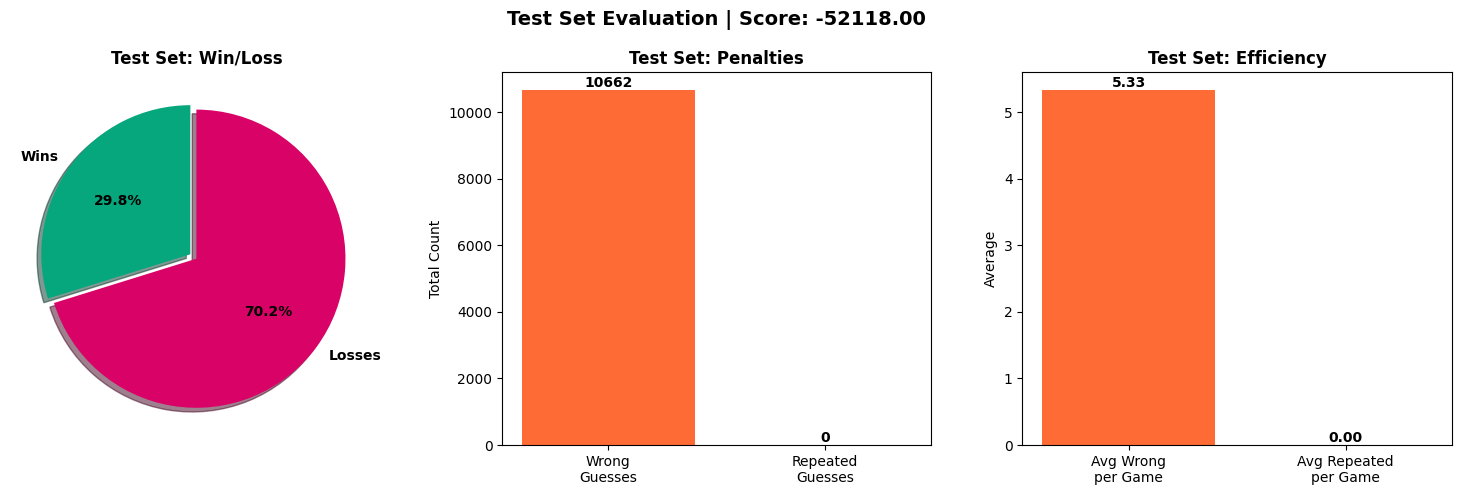

In [31]:
# ============================================================================
# CELL 9: Test Results Visualization
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Win/Loss pie
ax1 = axes[0]
sizes = [results['wins'], results['total_games'] - results['wins']]
colors = ['#06A77D', '#D90368']
explode = (0.05, 0)
ax1.pie(sizes, explode=explode, labels=['Wins', 'Losses'], colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontweight': 'bold'})
ax1.set_title('Test Set: Win/Loss', fontweight='bold', fontsize=12)

# Guesses breakdown
ax2 = axes[1]
categories = ['Wrong\nGuesses', 'Repeated\nGuesses']
values = [results['total_wrong'], results['total_repeated']]
bars = ax2.bar(categories, values, color=['#FF6B35', '#D90368'])
ax2.set_title('Test Set: Penalties', fontweight='bold', fontsize=12)
ax2.set_ylabel('Total Count')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Average metrics
ax3 = axes[2]
metrics = ['Avg Wrong\nper Game', 'Avg Repeated\nper Game']
avg_values = [results['total_wrong']/results['total_games'],
              results['total_repeated']/results['total_games']]
bars = ax3.bar(metrics, avg_values, color=['#FF6B35', '#D90368'])
ax3.set_title('Test Set: Efficiency', fontweight='bold', fontsize=12)
ax3.set_ylabel('Average')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle(f'Test Set Evaluation | Score: {results["final_score"]:.2f}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [39]:
def play_interactive_demo(agent, env, num_games=5):
    print("\n" + "=" * 60)
    print("DEMO: WATCH AGENT PLAY TEST WORDS")
    print("=" * 60)

    for game_num in range(num_games):
        print(f"\n{'='*50}")
        print(f"  GAME {game_num + 1}/{num_games}")
        print(f"{'='*50}")

        state = env.reset()
        print(f"Word length: {state['word_length']} letters")

        step = 1
        while not state['game_over']:
            print(f"\nStep {step}:")
            print(f"  Current:  {state['masked_word']}")
            print(f"  Lives:    {'❤️ ' * state['lives_remaining']}{'🖤 ' * (6 - state['lives_remaining'])}")

            # HMM predictions
            preds = agent.hmm.get_best_guess(
                state['masked_word'],

                state['guessed_letters'],
                top_n=3
            )
            print("  HMM says: " + ", ".join([f"{l}({p:.2f})" for l, p in preds]))

            # RL Agent chooses
            valid_actions = env.get_valid_actions()
            action = agent.get_action(state, valid_actions, training=False)
            print(f"  Agent chooses: {action}")

            # ✅ Corrected line
            state, reward, done, info = env.step(action)

            # Feedback
            if info.get("correct"):
                print(f"  ✅ Correct ({reward:+.0f})")
            elif info.get("repeated"):
                print(f"  ⚠️ Repeated ({reward:+.0f})")
            else:
                print(f"  ❌ Wrong ({reward:+.0f})")

            step += 1

        # Game over
        stats = env.get_stats()
        print(f"\n{'='*50}")
        if stats["won"]:
            print(f"🎉 WON! Word was: {stats['target_word']}")
        else:
            print(f"💀 LOST! Word was: {stats['target_word']}")
        print(f"Wrong: {stats['wrong_guesses']}, Repeated: {stats['repeated_guesses']}")
play_interactive_demo(agent, test_env, num_games=3)



DEMO: WATCH AGENT PLAY TEST WORDS

  GAME 1/3
Word length: 8 letters

Step 1:
  Current:  ________
  Lives:    ❤️ ❤️ ❤️ ❤️ ❤️ ❤️ 
  HMM says: E(0.11), A(0.09), I(0.08)
  Agent chooses: E
  ✅ Correct (+5)

Step 2:
  Current:  _____EE_
  Lives:    ❤️ ❤️ ❤️ ❤️ ❤️ ❤️ 
  HMM says: R(0.10), A(0.09), N(0.08)
  Agent chooses: N
  ❌ Wrong (-10)

Step 3:
  Current:  _____EE_
  Lives:    ❤️ ❤️ ❤️ ❤️ ❤️ 🖤 
  HMM says: R(0.10), A(0.10), L(0.07)
  Agent chooses: R
  ✅ Correct (+5)

Step 4:
  Current:  ___R_EE_
  Lives:    ❤️ ❤️ ❤️ ❤️ ❤️ 🖤 
  HMM says: A(0.11), O(0.08), S(0.08)
  Agent chooses: A
  ❌ Wrong (-10)

Step 5:
  Current:  ___R_EE_
  Lives:    ❤️ ❤️ ❤️ ❤️ 🖤 🖤 
  HMM says: O(0.09), S(0.09), L(0.08)
  Agent chooses: O
  ✅ Correct (+5)

Step 6:
  Current:  _OOR_EE_
  Lives:    ❤️ ❤️ ❤️ ❤️ 🖤 🖤 
  HMM says: S(0.10), T(0.10), $(0.09)
  Agent chooses: S
  ❌ Wrong (-10)

Step 7:
  Current:  _OOR_EE_
  Lives:    ❤️ ❤️ ❤️ 🖤 🖤 🖤 
  HMM says: T(0.11), $(0.10), D(0.10)
  Agent chooses: T
  ❌ Wrong (-10

In [40]:
import gradio as gr
import numpy as np

# Ensure model and environment exist
try:
    env
except NameError:
    env = HangmanEnvironment(corpus)
try:
    hmm
except NameError:
    hmm = HybridHangmanHMM()
    hmm.train(corpus)
try:
    agent
except NameError:
    agent = HangmanRLAgent(hmm, alpha=0.1, gamma=0.95, epsilon=0.1)


# --- Core evaluation function ---
def evaluate_word(word):
    """
    Simulate Hangman for the given word using trained HMM + RL agent
    and return the predicted progress and metrics.
    """
    state = env.reset(word)
    total_reward = 0
    guessed_sequence = []

    while not state['game_over']:
        # Choose best letter from HMM
        next_guess = agent.hmm.get_best_guess(state['masked_word'], state['guessed_letters'])[0][0]
        guessed_sequence.append(next_guess)
        state, reward, done, _ = env.step(next_guess)
        total_reward += reward

    stats = env.get_stats()
    predicted_word = ''.join(state['masked_word'])
    success_rate = 1.0 if stats['won'] else 0.0
    win_rate = f"{success_rate * 100:.2f}%"

    metrics = {
        "Target Word": stats['target_word'],
        "Predicted Word": predicted_word,
        "Guessed Sequence": " → ".join(guessed_sequence),
        "Final Score": total_reward,
        "Success Rate": success_rate,
        "Average Wrong Guesses": stats['wrong_guesses'],
        "Average Repeated Guesses": stats['repeated_guesses'],
        "Average Reward per Episode": total_reward,
        "Win Rate": win_rate
    }
    return metrics


# --- Display logic for Gradio ---
def display_results(word):
    metrics = evaluate_word(word)
    table = "\n".join([f"{k}:** {v}" for k, v in metrics.items()])
    return table


# --- Gradio Interface ---
interface = gr.Interface(
    fn=display_results,
    inputs=gr.Textbox(label="Enter Word", placeholder="Type a word here..."),
    outputs=gr.Markdown(label="Prediction & Performance"),
    title="Hangman Intelligent Agent Evaluator",
    description="Enter any word to see how your trained HMM + RL agent predicts and performs."
)

if __name__ == "__main__":
    interface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a4f1e556e3ab10d70f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
